# Negative Fake Companion Technique 
## Using GPU

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

2023-05-16 14:10:18.670548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:10:19.472517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-16 14:10:19.472582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-16 14:10:19.472589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Loading data

In [47]:
root = './data/DHTau/'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 80, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 3, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

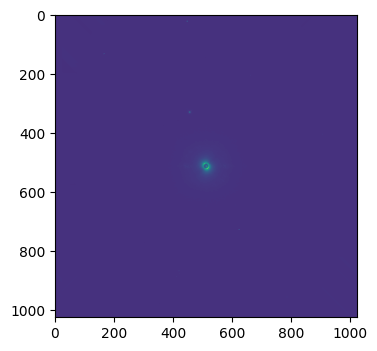

In [48]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [49]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

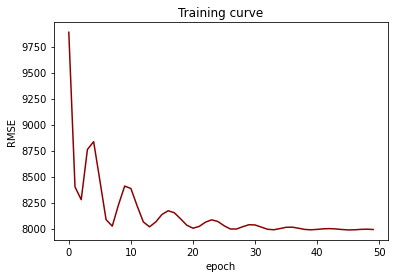

In [50]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [51]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

TensorShape([3, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [52]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

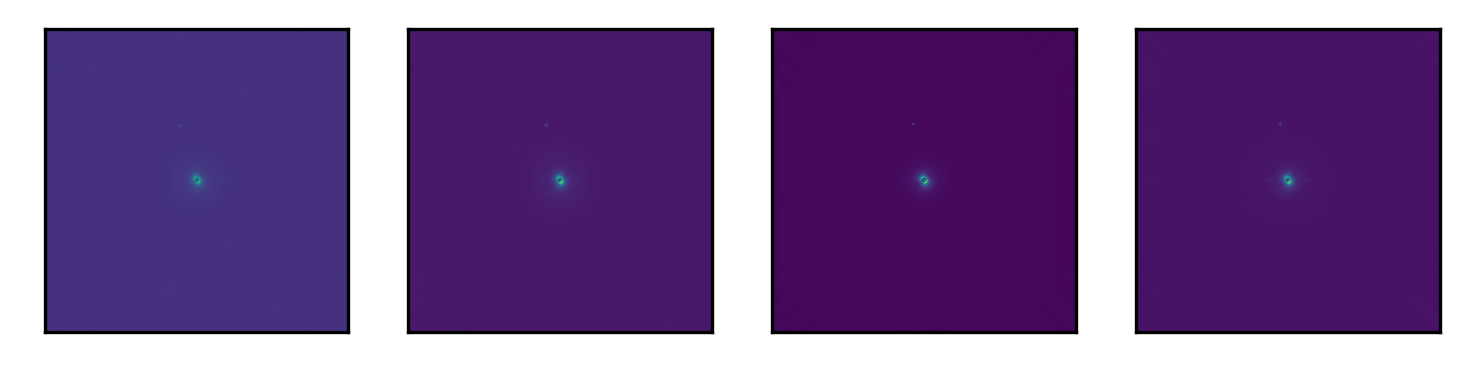

In [53]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [54]:
cube[0].shape

(80, 1024, 1024)

In [55]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], rot_ang, out_size=cube[0].shape, ncomp=1, derotate='tf')

CPU times: user 426 ms, sys: 671 ms, total: 1.1 s
Wall time: 1.64 s


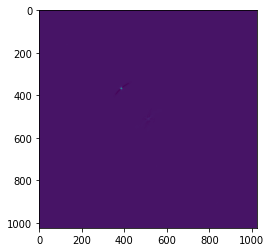

In [56]:
plt.imshow(adi_image)

In [57]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 8.04 s, sys: 37 ms, total: 8.08 s
Wall time: 7.97 s


In [58]:
table

,x,y,flux,fwhm_mean,snr
0,386.426361,367.135071,27.748566,4.063258,51.818754
1,503.281830,506.804626,0.855312,2.377028,1.845795
2,503.608093,518.126343,0.606163,3.675300,1.592760
3,513.070435,554.878113,0.174454,5.702561,2.040489
4,517.030640,546.720825,0.170452,5.012436,1.882538
5,459.859802,550.403442,0.161195,6.930292,3.070500
6,504.411407,472.870758,0.137701,3.301081,0.874835
7,461.543365,543.040527,0.134698,6.379208,2.089743
8,550.993103,730.697815,0.132690,4.661321,17.349393
9,552.550964,480.113983,0.126858,7.032731,1.950375


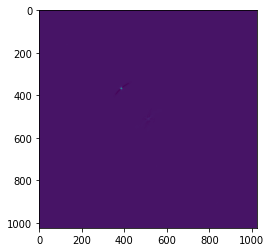

In [59]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [84]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers.experimental import SGD
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
def wrapper(fn, fwhm, std=True):
    def inner(*args):
        out = fn(*args, fwhm=fwhm, std=std)
        return out
    return inner

In [93]:
nfwhm = 2
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean']*nfwhm, std=False)

dataset, recovery = get_dataset(cube, normalized_psf, rot_ang, normalize=0)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    
# model.summary()

(336.4263610839844, 436.4263610839844)

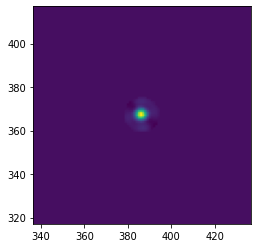

In [94]:
x_ = table.iloc[0]['x']
y_ = table.iloc[0]['y']
fwhm_ = table.iloc[0]['fwhm_mean']

obj_reg = tfnegfc.get_objective_region(adi_image, x_, y_, rot_ang, fwhm_*nfwhm)
plt.figure()
plt.imshow(obj_reg[0])
plt.ylim(y_-50, y_+50)
plt.xlim(x_-50, x_+50)

In [ ]:
%%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=40,
)
model.compile(loss_fn=custom_loss_w, optimizer=Adam(1))

hist = model.fit(dataset, epochs=500, verbose=1, callbacks=[es])

Epoch 1/500


2023-05-16 14:37:39.092142: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


1/1 [==============================] - 5s 5s/step - loss: 0.0045
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 8/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 9/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 10/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 11/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 12/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 13/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 1

1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 107/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 108/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 109/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 110/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 111/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 112/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 113/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 114/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 115/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 116/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 117/500
1/1 [==============================] - 1s 1s/step - loss: 0.0045
Epoch 118/500
1/1 [==============================] - 1s 1s/step - 

In [ ]:
plt.plot(hist.history['loss'])

In [44]:
x_firstguess = model.trainable_variables[0]
y_firstguess = model.trainable_variables[1]
flux_firstguess = model.trainable_variables[2]#*(recovery[0]-recovery[0]) + recovery[0]
flux_firstguess = flux_firstguess[0]
print('flux: {}'.format(flux_firstguess))

flux: 67.46623992919922


In [45]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_zeros = tfnegfc.inject_fake(x=x_firstguess, y=y_firstguess, flux = -flux_firstguess, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

Text(0.5, 1.0, 'Residuals')

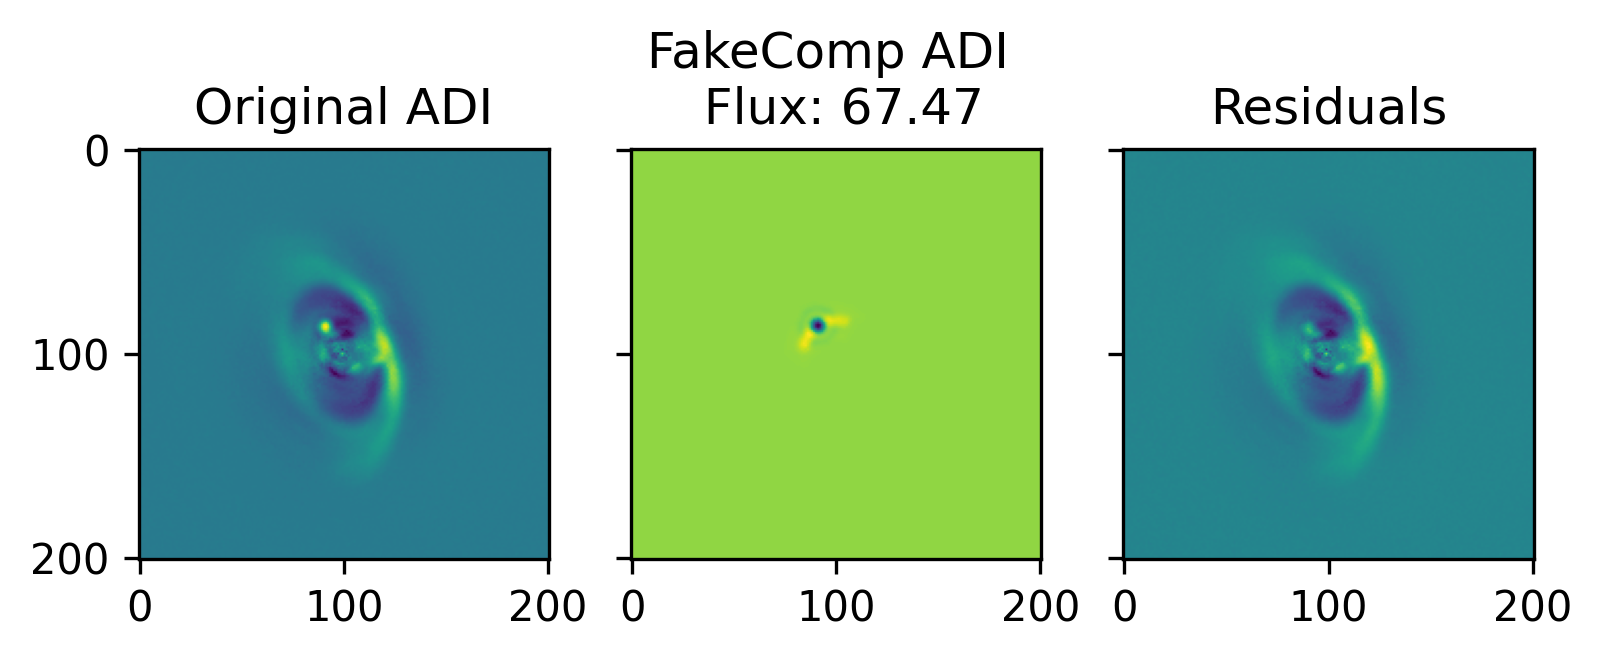

In [46]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(adi_image)
axes[0].set_title('Original ADI')
axes[1].imshow(adi_image_fake_zeros)
axes[1].set_title('FakeComp ADI \n Flux: {:.2f}'.format(flux_firstguess))
axes[2].imshow(adi_image+adi_image_fake_zeros)
axes[2].set_title('Residuals')

# axes[2].set_xlim(x_firstguess-100, x_firstguess+100)
# axes[2].set_ylim(y_firstguess-100, y_firstguess+100)

### MCMC

In [240]:
from gpu.mcmc import run_chain, run_chain_only_flux

In [241]:
# %%time
# init_state = [x_firstguess.numpy()[0], y_firstguess.numpy()[0], flux_firstguess]
# results = run_chain(init_state, fwhm_*2, cube[0], normalized_psf[0], 
#                     rot_ang, num_results=10000)
# titles = ['x', 'y', 'flux']

In [242]:
%%time
init_state = [flux_firstguess]

results = run_chain_only_flux(init_state, 
                              x_firstguess, 
                              y_firstguess, 
                              table.iloc[0]['fwhm_mean']*3, 
                              cube[0], 
                              normalized_psf[0], 
                              rot_ang, 
                              num_results=5000)
titles = ['flux']

/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
2023-05-15 19:24:04.386076: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/transformed_kernel_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/cond_1/branch_executed/_41


CPU times: user 1min 47s, sys: 9.68 s, total: 1min 57s
Wall time: 44.5 s


In [245]:
start = 0
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

tf.Tensor(67.46807, shape=(), dtype=float32)  -  87.77761


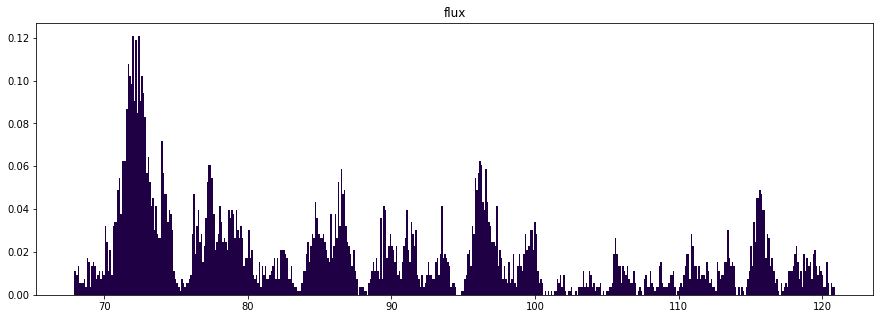

In [246]:
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
    
for i, r in enumerate(samples):
    axes[i].hist(np.ravel(r), bins=500, color='#200044', density=True)
    axes[i].set_title(titles[i])

## Visualizing Results

In [247]:
try:
    x_star = opt_values[0]
    y_star = opt_values[1]
    flux_star = opt_values[2]
except:
    x_star = x_firstguess.numpy()[0]
    y_star = y_firstguess.numpy()[0]
    flux_star = opt_values[0]

In [248]:
x_star, y_star, flux_star

(91.43079, 86.833885, 87.77761)

In [249]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = patch, 
                                rot_angles = rot_ang)

fake_cube_adi = tfnegfc.apply_adi(fake_cube, 
                                  rot_ang, 
                                  out_size=(cube[0].shape),
                                  ncomp=1, 
                                  derotate='tf')

In [ ]:
plt.figure(figsize=(5,5),dpi=200)
plt.imshow(fake_cube_adi)
plt.title('(x, y) = ({:.2f}, {:.2f}) - flux {:.2f}'.format(x_star, y_star, flux_star))
plt.xticks([])
plt.yticks([])
plt.show()